Likelihood of Seeing LoE Cards in Arena Draft
========================

Once Wing 4 of League of Explorers launches, and LoE cards get their 25% boost, how will this affect Arena Drafts?

To find out, I've run a Monte Carlo simulation of 10,000 drafts for each Player Class, and the results were somewhat surprising.  In summary:

* Most surprising, the **LoE Rare Class Cards** will be seen in about *55%* of Drafts.
* The new **LoE Class Commons** will be seen in about *71%* of Drafts.
* The **LoE Legendaries** (Reno, Elise, etc.) will each show up in about *1%* of Drafts.
* The **LoE Neutral Epics** (Djinni of Zephyrs and Naga Sea Witch) will show up in *8%* of Drafts.
* And finally, **LoE Neutral Commons** (Jeweled Scarab, etc.) will show up in about 39% of Drafts.

By **Drafts**, I mean as one of the 90 cards seen during the Draft.  Obviously, the percentage seen in actual Decks will differ (I ran out of time, but the next step would be to re-run the Monte Carlo simulation choosing the best card from the tier list to get a rough estimate of likelihood of seeing these cards in actual decks).

Below is the code (ipython notebook) used to explore this, as well as graphs of the top 30 cards in each Monte Carlo run.

Assumptions:

* LoE bonus is +25%
* Class bonus is +100% (not double, so a class LoE is 2.25x more likely, not 2.5x)
* Standard Draft rates are Common 78.6%, Rare 16.9%, Epic 3.76%, Legendary 0.75% (with Rares always on picks 1,15,30).

The helper.draft code is available in my [github repo](https://github.com/ryanschneider/arena-datascience).

In [55]:
%matplotlib inline
# Enable autoreload when debugging
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np

import random
import json
from collections import Counter

from helpers.draft import cards_df, draft_options, player_classes

In [59]:
# Ideally, simulating a draft would be faster..
%timeit draft_options("Druid")
#[ {row.iloc[0].rarity: row["name"].values.tolist() } for row in draft_options("Druid")]

10 loops, best of 3: 46.5 ms per loop


In [60]:
# Simulate 10000 drafts per Class, this'll take awhile (like an hour..)
likely_cards = dict()

for cls in player_classes:
    names = []
    card_counts = Counter()

    for i in range(10000):
        options = draft_options(cls)
        for option in options:
            names = option["name"].values
            card_counts.update(names)
            
    likely_cards[cls] = card_counts

In [61]:
# How likely is Reno Jackson in each Class?
for cls, card_counts in likely_cards.items():
    print("{}: {}".format(cls, card_counts["Reno Jackson"] / 10000.0))

Warlock: 0.0107
Warrior: 0.0118
Paladin: 0.012
Rogue: 0.0103
Hunter: 0.0101
Druid: 0.011
Priest: 0.012
Shaman: 0.0115
Mage: 0.0122


In [62]:
# What about the Neutral Epics
for cls, card_counts in likely_cards.items():
    print("{}: {}".format(cls, card_counts["Djinni of Zephyrs"] / 10000.0))

Warlock: 0.0765
Warrior: 0.0846
Paladin: 0.0826
Rogue: 0.086
Hunter: 0.0809
Druid: 0.0821
Priest: 0.0807
Shaman: 0.0803
Mage: 0.0788


In [63]:
# And Neutral Commons?
# What about the Neutral Epics
for cls, card_counts in likely_cards.items():
    print("{}: {}".format(cls, card_counts["Jeweled Scarab"] / 10000.0))

Warlock: 0.3843
Warrior: 0.3927
Paladin: 0.4059
Rogue: 0.3972
Hunter: 0.3948
Druid: 0.3908
Priest: 0.3889
Shaman: 0.3938
Mage: 0.3938


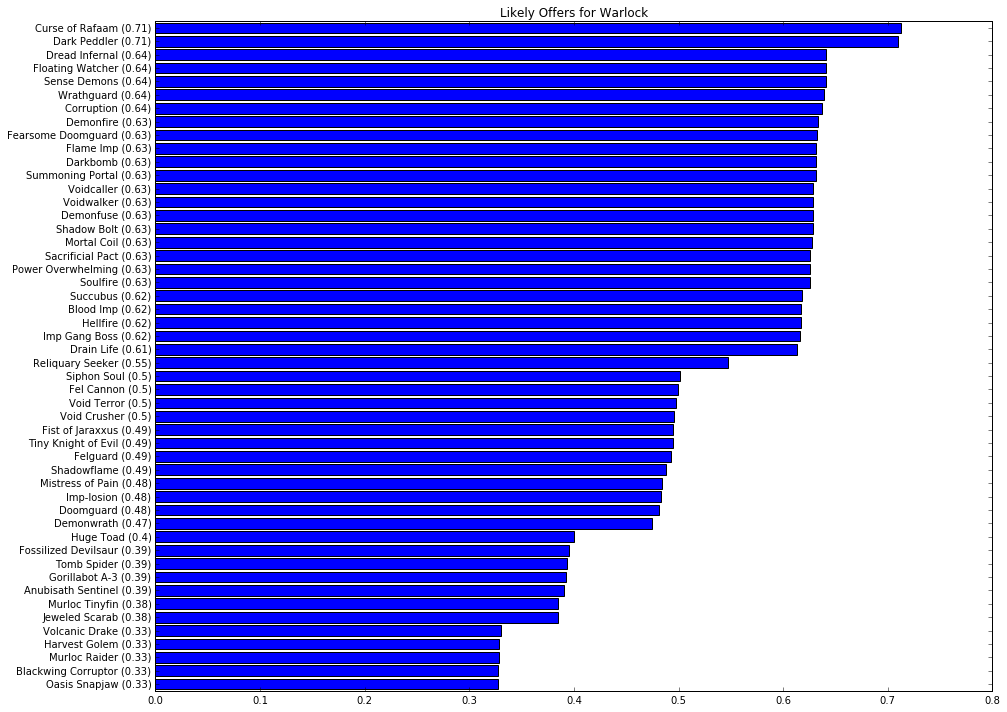

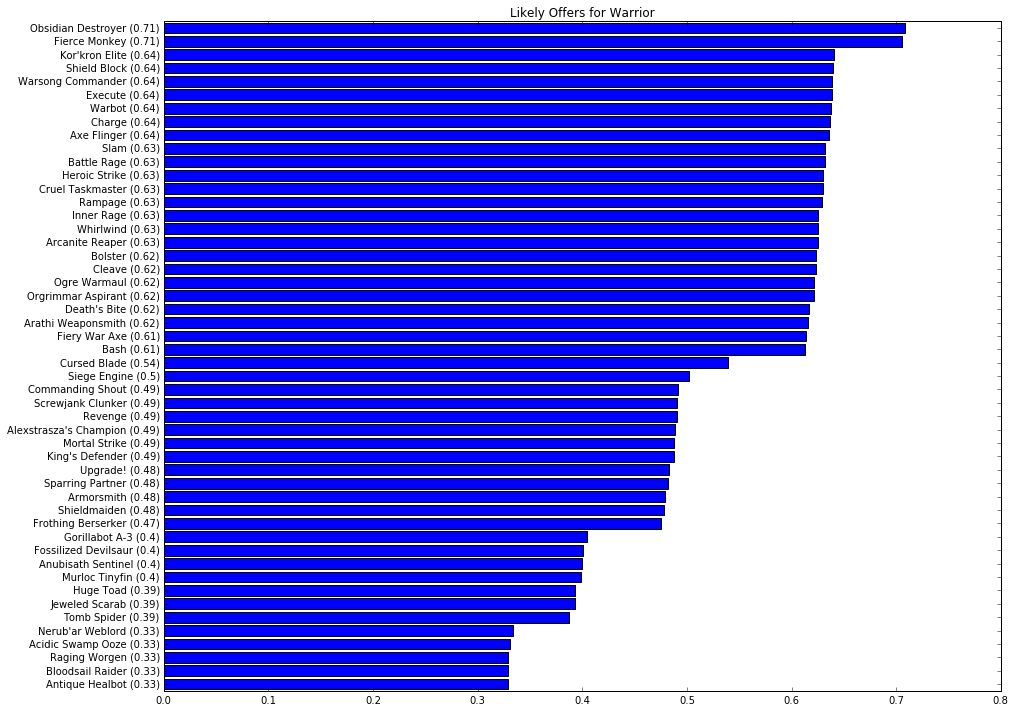

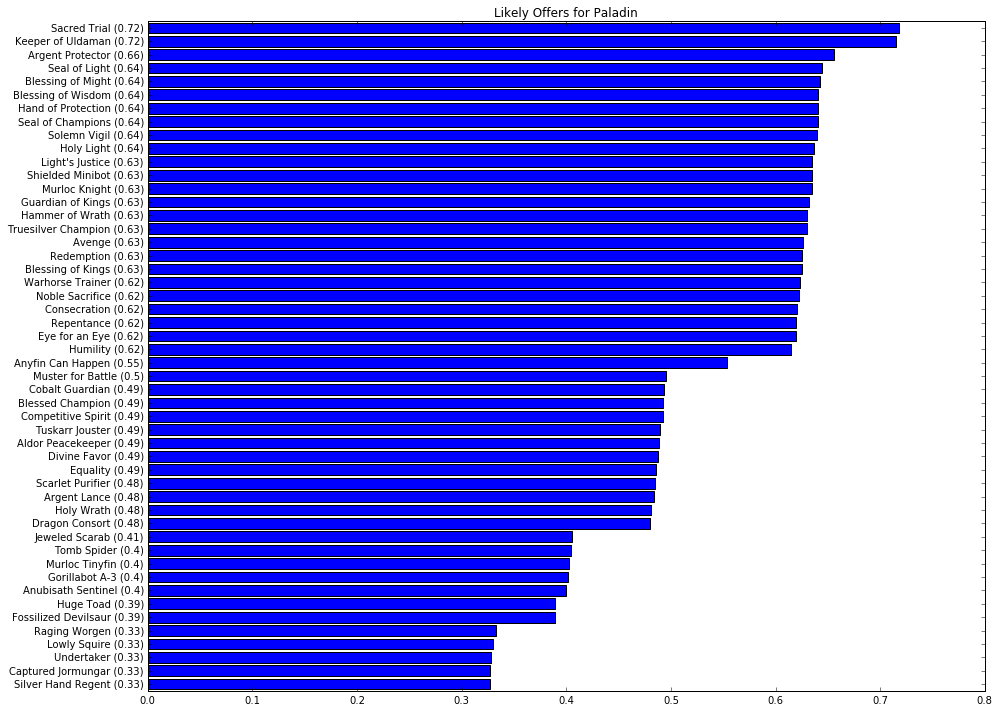

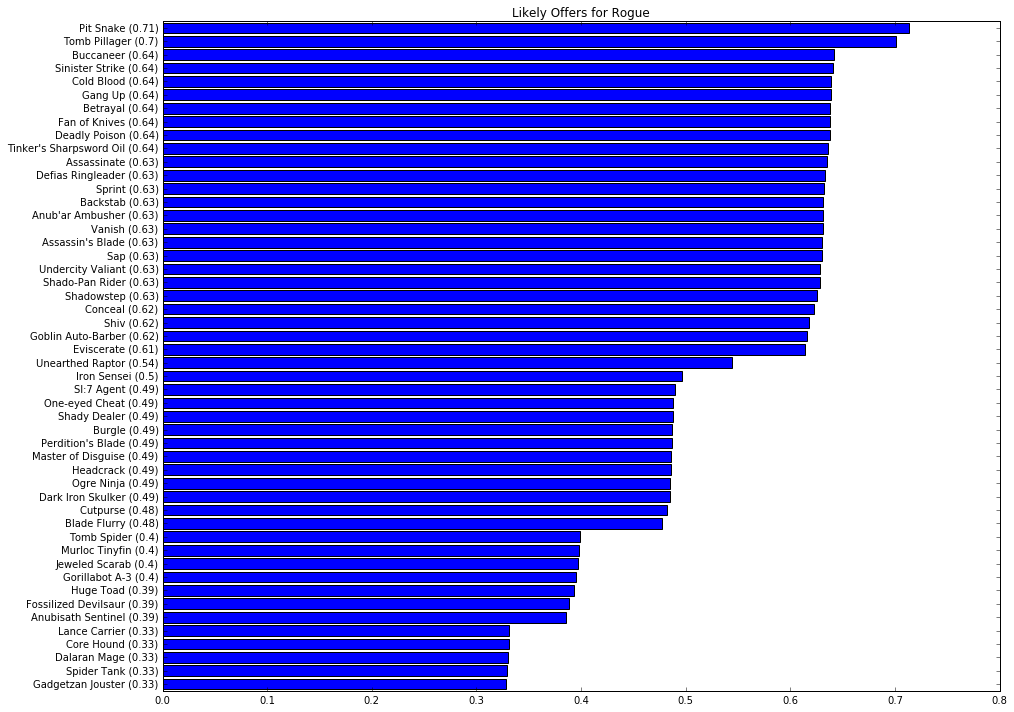

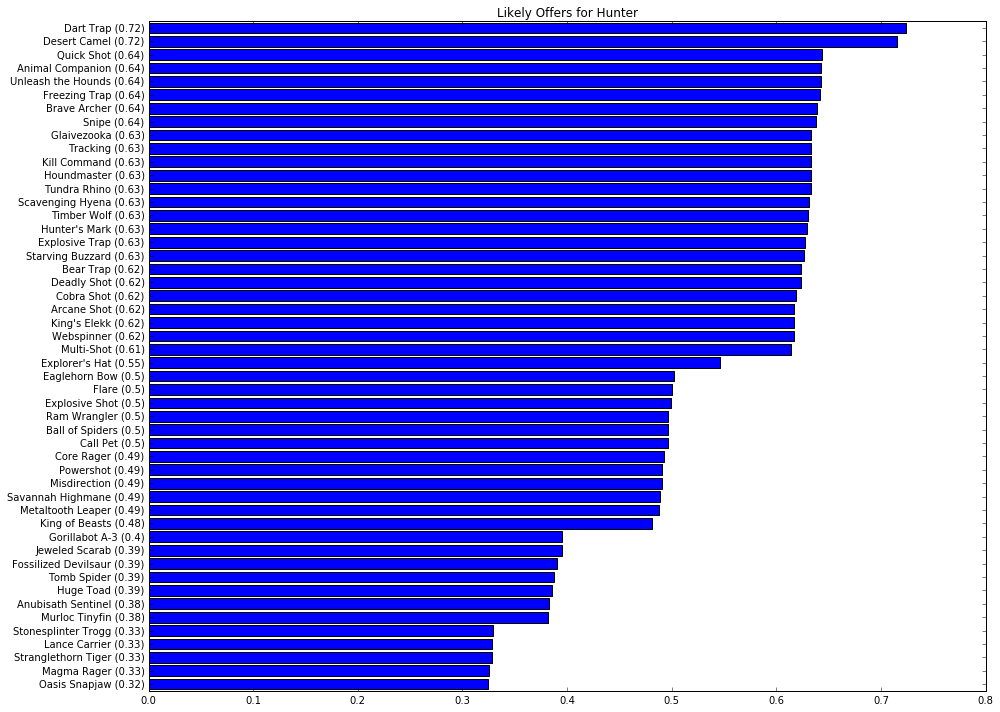

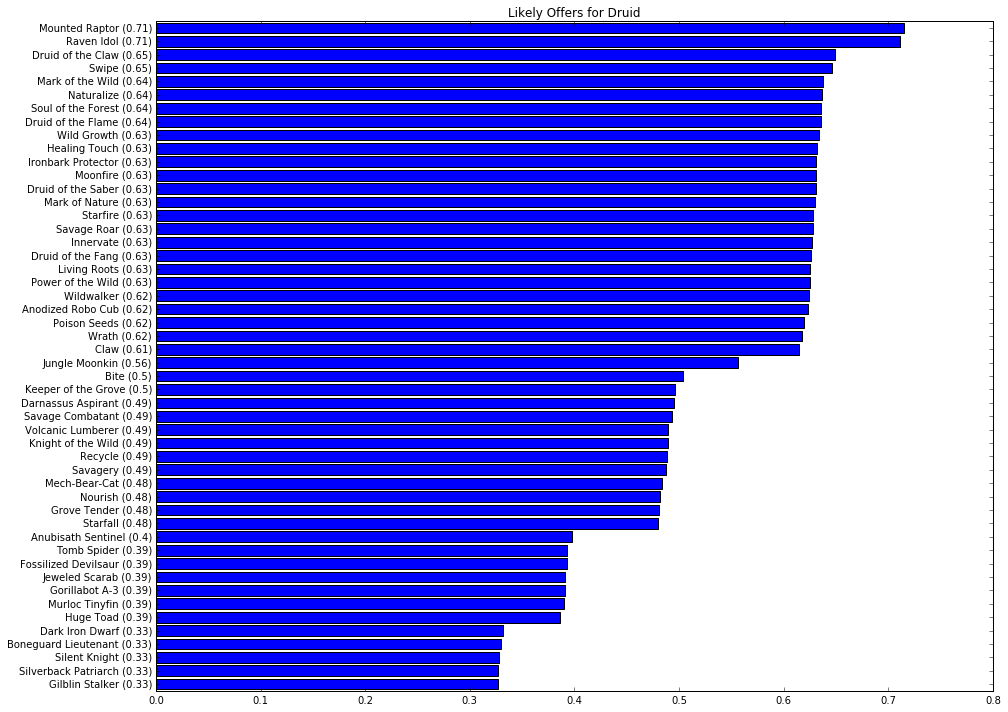

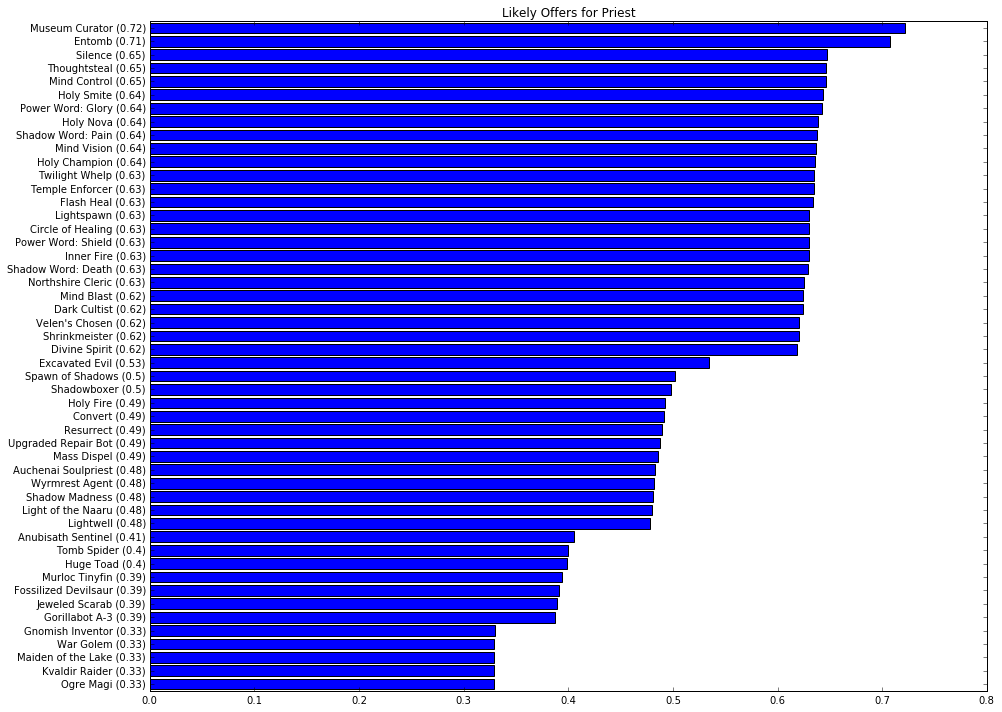

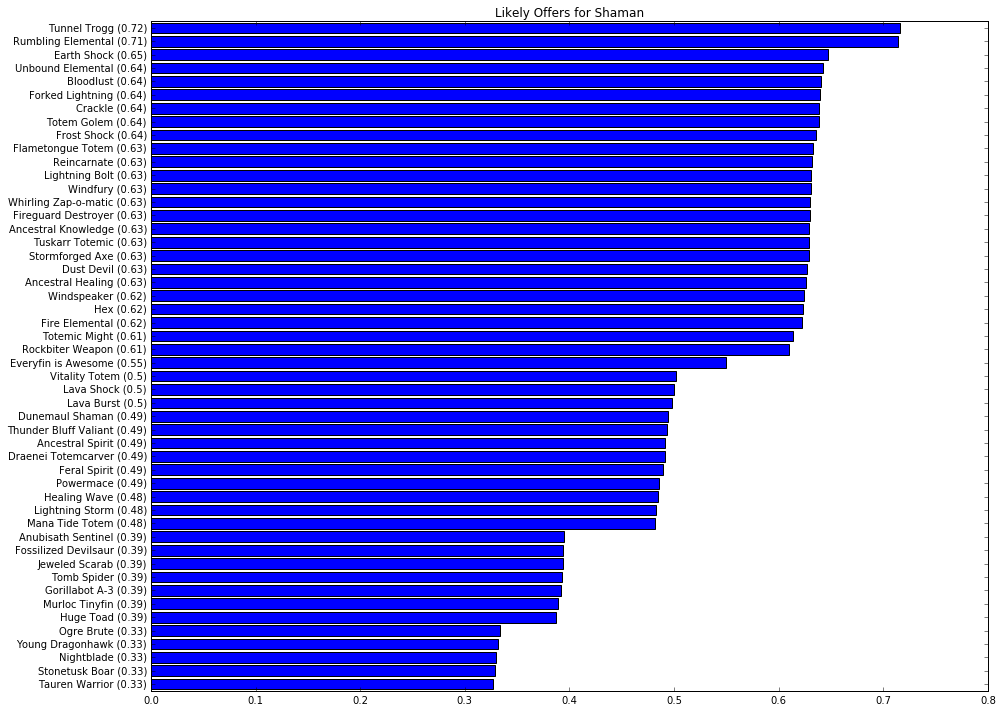

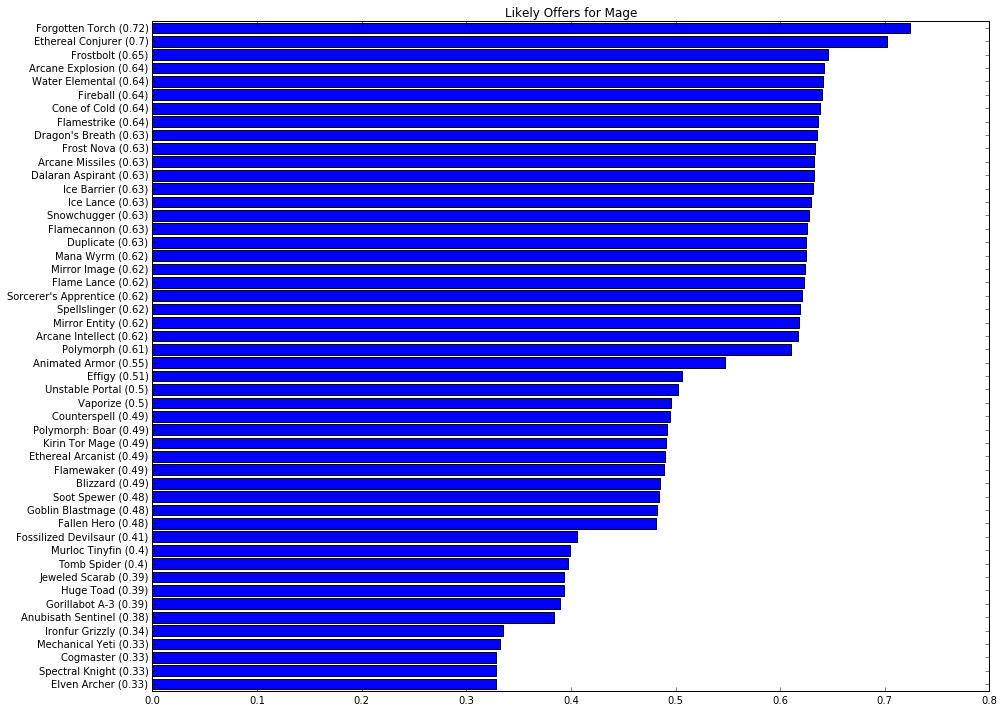

In [64]:
# And then graph them all using pyplot
for cls, card_counts in likely_cards.items():
    n = 50
    top = card_counts.most_common(n)
    pos = np.arange(n) + 0.5
    offer_labels = ["{} ({})".format(t[0], round(t[1] / 10000.0,2)) for t in reversed(top)]
    offer_counts = [t[1] / 10000.0 for t in reversed(top)]

    matplotlib.rcParams['figure.figsize'] = (15, 12)

    fig, ax = plt.subplots()
    rects = plt.barh(pos, offer_counts, align="center")
    plt.title("Likely Offers for {}".format(cls))
    plt.yticks(pos, offer_labels)
    plt.show()
